In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datacompy
import os
import numpy as np
from scipy.io import arff

# narzedzia
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    cross_val_predict,
    learning_curve,
    RepeatedStratifiedKFold,
    GridSearchCV
)
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import tree
from sklearn.tree import plot_tree
from sklearn.preprocessing import LabelEncoder

# modele + Smote
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from ctgan import CTGAN

In [23]:
# code
df = pd.read_csv("D:/ml/xgboost-main/data/spambase/spambase.csv")
df = df.drop_duplicates()
print(df.head())
print(df.dtypes)

#add new column = "source" with value = "oryginal" and save
path = "D:\\ml\\xgboost-main\\data\\spambase\\oryginal_dataset.csv"
df = df.copy()
df['source'] = 'original'
df.to_csv(path)

   word_freq_make  word_freq_address  word_freq_all  word_freq_3d  \
0            0.00               0.64           0.64           0.0   
1            0.21               0.28           0.50           0.0   
2            0.06               0.00           0.71           0.0   
3            0.00               0.00           0.00           0.0   
4            0.00               0.00           0.00           0.0   

   word_freq_our  word_freq_over  word_freq_remove  word_freq_internet  \
0           0.32            0.00              0.00                0.00   
1           0.14            0.28              0.21                0.07   
2           1.23            0.19              0.19                0.12   
3           0.63            0.00              0.31                0.63   
4           0.63            0.00              0.31                0.63   

   word_freq_order  word_freq_mail  ...  char_freq_;  char_freq_(  \
0             0.00            0.00  ...         0.00        0.000   
1 

### Training & Test Data

In [24]:
df2 = df.drop(columns="source")
y = df2["spam"]
X = df2.drop(columns=["spam"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape)
print(X_test.shape)

#concat X_train & y_train -> used to save files
df_original = pd.concat([X_train, y_train], axis=1)          
df_original['source'] = 'original'  

#save test samples
y_test.to_csv("D:\\ml\\xgboost-main\\data\\spambase\\test_data\\y_test.csv")
X_test.to_csv("D:\\ml\\xgboost-main\\data\\spambase\\test_data\\X_test.csv")

(3368, 57)
(842, 57)


### Oversampling - SMOTE

Przed Counter({0: 2010, 1: 1358})
Po Counter({0: 2010, 1: 2010})
Plik istnieje pod ścieżką: D:\ml\xgboost-main\data\spambase\smote_data.csv


<Axes: xlabel='spam'>

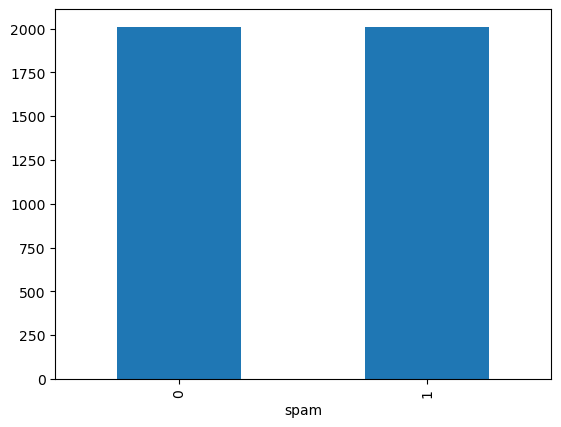

In [39]:
file_path1 = "D:\\ml\\xgboost-main\\data\\spambase\\smote_data.csv"
#generate new data by SMOTE
con = Counter(y_train)
print("Przed", con)
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)
con1 = Counter(y_train_sm)
print("Po", con1)

#concat smote train X & y && save data
train_data_smote = pd.concat([X_train_sm, y_train_sm], axis=1)          #polaczenie danych wygenerowanych X_train oraz y_train
train_data_smote['generated_by_smote'] = ['original' if i < len(df_original) else 'smote' for i in range(len(train_data_smote))]
smote_data = train_data_smote[train_data_smote['generated_by_smote'] == 'smote'].drop('generated_by_smote', axis=1)
smote_data["source"]="smote"

if not os.path.exists(file_path1):
    smote_data.to_csv(file_path1, index=False)
else:
    print(f'Plik istnieje pod ścieżką: {file_path1}')

pd.Series(y_train_sm).value_counts().plot.bar()

### Oversampling - BorderLine SMOTE

Przed Counter({0: 2010, 1: 1358})
Po Counter({0: 2010, 1: 2010})


<Axes: xlabel='spam'>

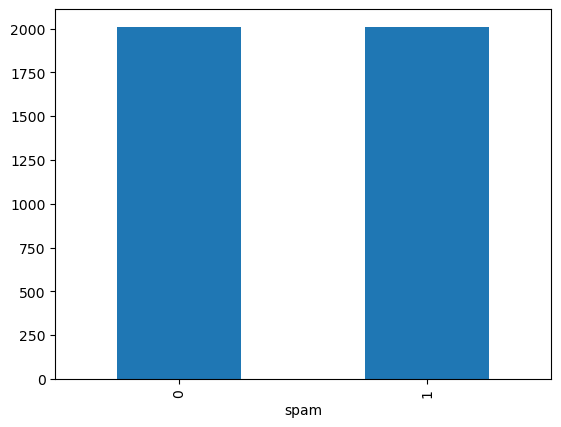

In [42]:
file_path2 = "D:\\ml\\xgboost-main\\data\\spambase\\boarderlinesmote_data.csv"
#generate new data by borderLineSMOTE
con3 = Counter(y_train)
print("Przed", con3)
brdsmote = BorderlineSMOTE(random_state=42)
X_train_bsm, y_train_bsm = brdsmote.fit_resample(X_train, y_train)
con4 = Counter(y_train_bsm)
print("Po", con4)

train_data_borderline_smote = pd.concat([X_train_bsm, y_train_bsm], axis=1)          #polaczenie danych wygenerowanych X_train oraz y_train
train_data_borderline_smote['generated_by_boarderline_smote'] = ['original' if i < len(df_original) else 'brd smote' for i in range(len(train_data_borderline_smote))]
boarderline_smote_data = train_data_borderline_smote[train_data_borderline_smote['generated_by_boarderline_smote'] == 'brd smote'].drop('generated_by_boarderline_smote', axis=1)
boarderline_smote_data["source"]="borderline smote"
if not os.path.exists(file_path2):
    boarderline_smote_data.to_csv(file_path2, index=False)
else:
    print(f'Plik istnieje pod ścieżką: {file_path2}')

pd.Series(y_train_bsm).value_counts().plot.bar()

### Oversampling - GAN

Przed Counter({0: 2010, 1: 1358})
Dane wygenerowane:  spam
1    652
Name: count, dtype: int64
Plik istnieje pod ścieżką: D:\ml\xgboost-main\data\generated\GAN_data.csv
Ilosc danych po generacji:
 Counter({0: 2010, 1: 2010})
Podzial danych treningowych
 Counter({0: 1608, 1: 1608})


<Axes: xlabel='spam'>

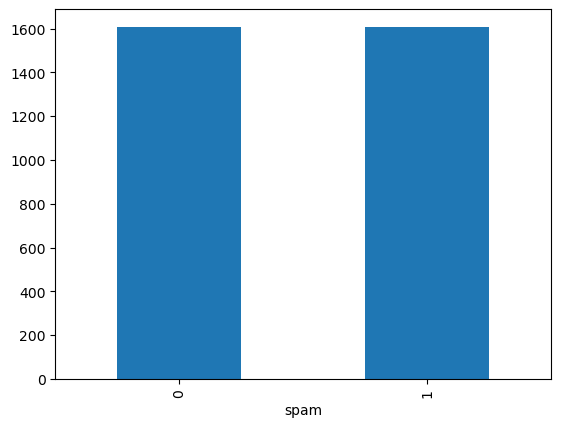

In [ ]:
file_path3 = "D:\\ml\\xgboost-main\\data\\spambase\\GAN_data.csv"        #sciezka wraz z nazwa pod jaka wygenerowac plik
#generate new data by GAN
columns_list = df_original.columns
target_num = df_original['spam'].value_counts()
ctgan = CTGAN(epochs=10)        #model

if target_num[0] > target_num[1]:
    data_y1 = df_original[df_original['spam']==1]
    ctgan.fit(data_y1, columns_list)
    sample = abs(target_num[0]-target_num[1])
    df_GAN = ctgan.sample(sample)
    print('Dane wygenerowane: ', df_GAN['spam'].value_counts())
    balanced_data = pd.concat([df_original, df_GAN], ignore_index=False)
else:
    data_y0 = df_original[df_original['spam']==0]
    ctgan.fit(data_y0, columns_list)
    sample = abs(target_num[0]-target_num[1])
    df_GAN = ctgan.sample(sample)
    print('Dane wygenerowane: ', df_GAN['spam'].value_counts())
    balanced_data = pd.concat([df_original, df_GAN], ignore_index=False)
  
y_train_gan = balanced_data["spam"]
X_train_gan = df.drop(columns=["spam"])
con5 = Counter(y_train)
print("Before", con5)
con6 = Counter(y_train_gan)
print("After", con6)

df_GAN["source"]="gan"
if not os.path.exists(file_path3):
    df_GAN.to_csv(file_path3, index=False)
else:
    print(f'Plik istnieje pod ścieżką: {file_path3}')

pd.Series(y_train_gan).value_counts().plot.bar()